<div style="direction: rtl; text-align: right;">

# گزارش مدل 1DCNN

## ۱. خواندن و آماده‌سازی داده‌ها

### پیش‌پردازش
- **خواندن داده‌ها**:
  - فایل‌های CSV با استفاده از `pd.read_csv` خوانده می‌شوند.
  - سیگنال‌ها (`sigs`) و برچسب‌ها (`labels`) جدا می‌شوند.
- **پردازش سیگنال‌ها**:
  - محدود کردن مقادیر خارج از ۹۹.۵ درصدile با `clip_signal`.
  - صاف‌سازی سیگنال‌ها با `smooth_signal` و هسته ۵.
  - کاهش اندازه به طول ثابت ۲۰۴۸ نمونه با `downsample_avg`.
- **ذخیره‌سازی**:
  - داده‌ها به صورت آرایه‌های NumPy ذخیره شده و در پوشه `cache_fast_norm` کش می‌شوند تا از بارگذاری مجدد جلوگیری شود.

### تقسیم داده‌ها
- داده‌ها به سه مجموعه تقسیم می‌شوند:
  - **آموزشی**: ۶۰٪
  - **اعتبارسنجی**: ۲۰٪
  - **تست**: ۲۰٪
- نرمال‌سازی با میانگین و انحراف معیار مجموعه آموزشی انجام می‌شود.

### داده‌افزایی (Augmentation)
- در مجموعه آموزشی:
  - نویز گاوسی
  - جابجایی
  - مقیاس‌دهی
  - افزونگی فرکانسی
- احتمال اعمال: ۳۰٪

## ۲. تعریف مدل CNN

مدل یک شبکه کانولوشنی یک‌بعدی (1D CNN) شامل موارد زیر است:

### لایه‌های کانولوشنی
- **conv1_large**:
  - ۲۴ فیلتر، اندازه هسته ۱۵، پدینگ ۷
  - MaxPooling با اندازه ۳
- **conv1_small**:
  - ۲۴ فیلتر، اندازه هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳
- **ترکیب**:
  - خروجی `conv1_large` و `conv1_small` با `torch.cat` ترکیب شده و به ۴۸ کانال می‌رسد.
- **conv2**:
  - ۹۶ فیلتر، هسته ۷، پدینگ ۳
  - MaxPooling با اندازه ۳
- **conv3**:
  - ۱۹۲ فیلتر، هسته ۵، پدینگ ۲
  - MaxPooling با اندازه ۳
- **conv4**:
  - ۲۵۶ فیلتر، هسته ۳، پدینگ ۱
  - `AdaptiveAvgPool1d` به طول ۱۶

### بلوک Squeeze-and-Excitation (SE)
- پس از `conv2`:
  - کاهش ۱۶ کانالی برای تنظیم پویای کانال‌ها

### Shortcut
- مسیر مستقیم با کانولوشن ۱×۱ و BatchNorm برای ادغام با خروجی اصلی

### لایه‌های Fully Connected
- لایه‌های خطی:
  - ۲۵۶ → ۱۲۸ → ۶۴
  - هر لایه با ReLU و Dropout (نسبت‌های ۰.۴۵، ۰.۳۵، ۰.۲۵)
- لایه خروجی نهایی:
  - ۱ نورون برای پیش‌بینی RUL

### جریان داده
- خروجی‌های کانولوشنی با اتصال کوتاه جمع شده و پس از فلتن کردن به طبقه‌بندی‌کننده منتقل می‌شوند.

## ۳. یادگیری مدل

### بهینه‌سازی
- بهینه‌ساز: **AdamW**
  - نرخ یادگیری اولیه: `1e-4`
  - وزن‌دهی: `3e-4`
- تابع هزینه: **Huber Loss**
  - دلتا: ۰.۳
  - ضرایب تنظیم:
    - L1: ۰.۰۵
    - L2: `3e-4`

### داده‌افزایی در آموزش
- **Mixup**:
  - آلفا: ۰.۲
  - احتمال: ۳۰٪

### برنامه‌ریزی نرخ یادگیری
- **ReduceLROnPlateau**:
  - فاکتور: ۰.۴
  - صبر: ۵

### زود متوقف شدن (Early Stopping)
- توقف آموزش پس از ۲۰ Epoch بدون بهبود.

### حفظ بهترین مدل
- ذخیره در: `best_model_cnn_improved.pth` (بر اساس کمترین خطای اعتبارسنجی)

## ۴. تست و نمایش نتایج

### ارزیابی
- معیارها:
  - MSE
  - MAE
  - RMSE
  - R²
  - sMAPE

### نمایش گرافیکی
- **نمودار پراکندگی**: پیش‌بینی‌شده در مقابل واقعی
- **Confusion Matrix**:
  - دسته‌بندی RUL به بازه‌ها:
    - [۰-۵۰۰]
    - [۵۰۰-۱۰۰۰]
    - [۱۰۰۰-۱۵۰۰]
    - [۱۵۰۰-۲۰۰۰]
    - [۲۰۰۰+]
- **تاریخچه Loss**:
  - نمایش Loss آموزشی و اعتبارسنجی

## ۵. نتایج

### نتایج آموزشی و اعتبارسنجی
- **توقف آموزش**: Epoch ۴۷ (Early Stopping پس از ۲۰ Epoch بدون بهبود)
- **بهترین عملکرد اعتبارسنجی** (Epoch ۲۷):
  - Loss: ۰.۰۰۸۰
  - sMAPE: ۴۰.۰۹٪

### نتایج تست
- **معیارها**:
  - MSE: ۹۹۶۰۲.۲۲
  - MAE: ۲۱۸.۵۰
  - RMSE: ۳۱۵.۶۰
  - R²: ۰.۸۲۱۱
  - sMAPE: ۴۰.۱۰٪
  - MAE%Max: ۸.۶۳٪

</div>


===== Epoch 1/100 =====


📉 Train=0.0280 | Val=0.0136 | Val sMAPE=59.54%
✅ (best).

===== Epoch 2/100 =====


📉 Train=0.0176 | Val=0.0122 | Val sMAPE=56.56%
✅ (best).

===== Epoch 3/100 =====


📉 Train=0.0161 | Val=0.0200 | Val sMAPE=61.80%

===== Epoch 4/100 =====


📉 Train=0.0157 | Val=0.0156 | Val sMAPE=49.33%

===== Epoch 5/100 =====


📉 Train=0.0143 | Val=0.0124 | Val sMAPE=51.21%

===== Epoch 6/100 =====


📉 Train=0.0137 | Val=0.0125 | Val sMAPE=48.74%

===== Epoch 7/100 =====


📉 Train=0.0131 | Val=0.0105 | Val sMAPE=47.36%
✅ (best).

===== Epoch 8/100 =====


📉 Train=0.0141 | Val=0.0107 | Val sMAPE=55.10%

===== Epoch 9/100 =====


📉 Train=0.0129 | Val=0.0118 | Val sMAPE=47.50%

===== Epoch 10/100 =====


📉 Train=0.0118 | Val=0.0103 | Val sMAPE=47.80%
✅ (best).

===== Epoch 11/100 =====


📉 Train=0.0115 | Val=0.0125 | Val sMAPE=50.36%

===== Epoch 12/100 =====


📉 Train=0.0120 | Val=0.0157 | Val sMAPE=50.63%

===== Epoch 13/100 =====


📉 Train=0.0112 | Val=0.0141 | Val sMAPE=50.12%

===== Epoch 14/100 =====


📉 Train=0.0102 | Val=0.0194 | Val sMAPE=55.50%

===== Epoch 15/100 =====


📉 Train=0.0116 | Val=0.0160 | Val sMAPE=52.89%

===== Epoch 16/100 =====


📉 Train=0.0115 | Val=0.0123 | Val sMAPE=47.04%

===== Epoch 17/100 =====


📉 Train=0.0099 | Val=0.0094 | Val sMAPE=45.22%
✅ (best).

===== Epoch 18/100 =====


📉 Train=0.0100 | Val=0.0093 | Val sMAPE=43.76%

===== Epoch 19/100 =====


📉 Train=0.0089 | Val=0.0090 | Val sMAPE=42.69%
✅ (best).

===== Epoch 20/100 =====


📉 Train=0.0108 | Val=0.0122 | Val sMAPE=45.27%

===== Epoch 21/100 =====


📉 Train=0.0099 | Val=0.0085 | Val sMAPE=41.86%
✅ (best).

===== Epoch 22/100 =====


📉 Train=0.0103 | Val=0.0092 | Val sMAPE=42.55%

===== Epoch 23/100 =====


📉 Train=0.0103 | Val=0.0090 | Val sMAPE=42.46%

===== Epoch 24/100 =====


📉 Train=0.0092 | Val=0.0088 | Val sMAPE=42.65%

===== Epoch 25/100 =====


📉 Train=0.0097 | Val=0.0098 | Val sMAPE=43.27%

===== Epoch 26/100 =====


📉 Train=0.0094 | Val=0.0093 | Val sMAPE=41.79%

===== Epoch 27/100 =====


📉 Train=0.0098 | Val=0.0080 | Val sMAPE=40.09%
✅ (best).

===== Epoch 28/100 =====


📉 Train=0.0096 | Val=0.0091 | Val sMAPE=41.84%

===== Epoch 29/100 =====


📉 Train=0.0089 | Val=0.0155 | Val sMAPE=48.48%

===== Epoch 30/100 =====


📉 Train=0.0098 | Val=0.0092 | Val sMAPE=41.68%

===== Epoch 31/100 =====


📉 Train=0.0096 | Val=0.0093 | Val sMAPE=41.76%

===== Epoch 32/100 =====


📉 Train=0.0083 | Val=0.0098 | Val sMAPE=41.33%

===== Epoch 33/100 =====


📉 Train=0.0081 | Val=0.0089 | Val sMAPE=40.78%

===== Epoch 34/100 =====


📉 Train=0.0081 | Val=0.0090 | Val sMAPE=40.66%

===== Epoch 35/100 =====


📉 Train=0.0082 | Val=0.0087 | Val sMAPE=40.47%

===== Epoch 36/100 =====


📉 Train=0.0089 | Val=0.0088 | Val sMAPE=40.47%

===== Epoch 37/100 =====


📉 Train=0.0099 | Val=0.0092 | Val sMAPE=41.14%

===== Epoch 38/100 =====


📉 Train=0.0091 | Val=0.0084 | Val sMAPE=40.34%

===== Epoch 39/100 =====


📉 Train=0.0088 | Val=0.0087 | Val sMAPE=40.72%

===== Epoch 40/100 =====


📉 Train=0.0083 | Val=0.0089 | Val sMAPE=40.80%

===== Epoch 41/100 =====


📉 Train=0.0092 | Val=0.0088 | Val sMAPE=40.87%

===== Epoch 42/100 =====


📉 Train=0.0095 | Val=0.0082 | Val sMAPE=40.50%

===== Epoch 43/100 =====


📉 Train=0.0083 | Val=0.0083 | Val sMAPE=39.85%

===== Epoch 44/100 =====


📉 Train=0.0090 | Val=0.0088 | Val sMAPE=40.88%

===== Epoch 45/100 =====


📉 Train=0.0083 | Val=0.0098 | Val sMAPE=42.04%

===== Epoch 46/100 =====


📉 Train=0.0085 | Val=0.0083 | Val sMAPE=39.93%

===== Epoch 47/100 =====


📉 Train=0.0099 | Val=0.0103 | Val sMAPE=42.60%
⏹️ Early stopping.


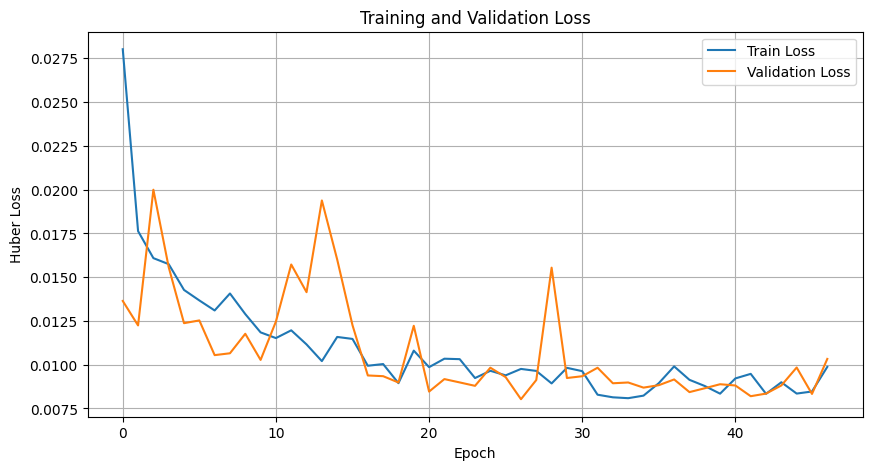

✅ Test: MSE=99602.22, MAE=218.50, RMSE=315.60, R2=0.8211, sMAPE=40.10%, MAE%Max=8.63%


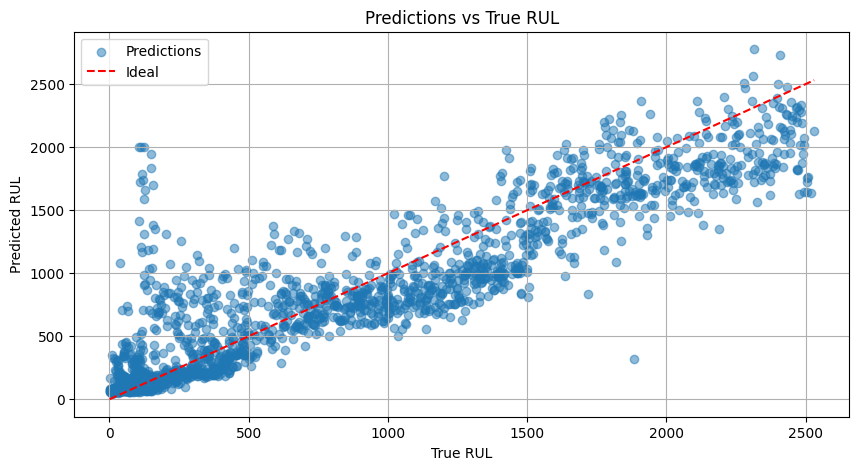

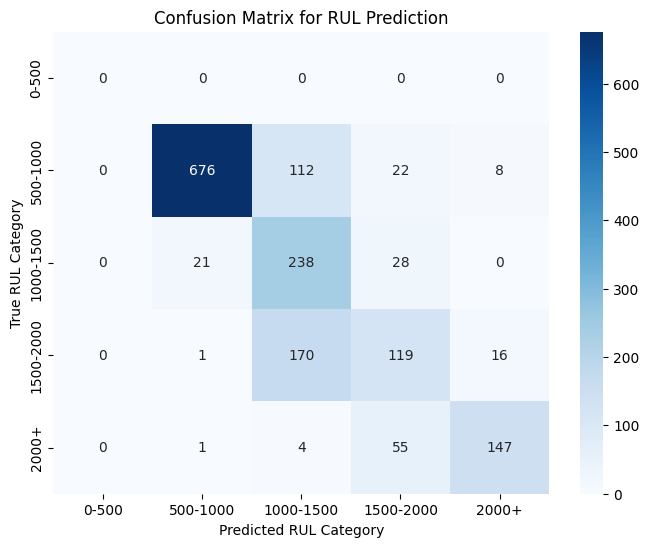

In [ ]:

import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


BASE_DIR = Path(r"D:\DRIVE\UNI\moviZ\TERM8\ANN-article--AzRiz\OurWorks\Data-description\phase1")
REVERSED_FOLDER = "reversed"
CACHE_DIR = Path("cache_fast_norm")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

TARGET_LEN = 2048
SMOOTH_KERNEL = 5
BATCH_SIZE = 64
EPOCHS = 100  
LR = 1e-4
WEIGHT_DECAY = 3e-4  
PATIENCE = 20  
VAL_RATIO = 0.2
TEST_RATIO = 0.2
SEED = 42
AUGMENT = True
DEBUG = False

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_num_threads(max(1, os.cpu_count() // 2))


def smooth_signal(x, kernel=SMOOTH_KERNEL):
    if kernel is None or kernel <= 1:
        return x.astype(np.float32, copy=False)
    k = np.ones(kernel, dtype=np.float32) / kernel
    return np.convolve(x.astype(np.float32, copy=False), k, mode='same')

def downsample_avg(signal, target_len):
    if len(signal) == target_len:
        return signal.astype(np.float32, copy=False)
    parts = np.array_split(signal, target_len)
    return np.array([p.mean(dtype=np.float32) for p in parts], dtype=np.float32)

def clip_signal(signal, clip_percentile=99.5):
    clip_value = np.percentile(np.abs(signal), clip_percentile)
    return np.clip(signal, -clip_value, clip_value)

def frequency_augmentation(signal, scale_range=(0.9, 1.1)):
    freq = np.fft.fft(signal)
    scale = np.random.uniform(*scale_range)
    freq = freq * scale
    return np.fft.ifft(freq).real.astype(np.float32)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def get_all_files(base_dir):
    files = list(base_dir.rglob(f"*/{REVERSED_FOLDER}/*.csv"))
    return sorted([f for f in files if f.is_file()])

def preprocess_and_cache(files):
    print("📦 Preprocessing & Caching (once)...")
    X_list, y_list = [], []
    max_rul = 0.0
    for f in tqdm(files):
        df = pd.read_csv(f, header=None, dtype=np.float32)
        sigs = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values.astype(np.float32)
        if labels.size == 0:
            continue
        max_rul = max(max_rul, float(labels.max()))
        for sig, lab in zip(sigs, labels):
            sig = clip_signal(sig)
            if SMOOTH_KERNEL > 1:
                sig = smooth_signal(sig, SMOOTH_KERNEL)
            sig_ds = downsample_avg(sig, TARGET_LEN)
            X_list.append(sig_ds)
            y_list.append(lab)
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    np.save(CACHE_DIR / "X_raw.npy", X)
    np.save(CACHE_DIR / "y.npy", y)
    np.save(CACHE_DIR / "max_rul.npy", np.array([max_rul], dtype=np.float32))
    print(f"✅ Cached raw: X={X.shape}, y={y.shape}, max_rul={max_rul:.2f}")

def load_cached_raw():
    X = np.load(CACHE_DIR / "X_raw.npy")
    y = np.load(CACHE_DIR / "y.npy")
    max_rul = float(np.load(CACHE_DIR / "max_rul.npy")[0])
    return X, y, max_rul

def split_indices(n_samples, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SEED):
    idx = np.arange(n_samples)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)
    n_test = int(test_ratio * n_samples)
    n_val = int(val_ratio * (n_samples - n_test))
    return idx[n_test + n_val:], idx[n_test:n_test + n_val], idx[:n_test]

def compute_train_norm_stats(X_train):
    mean = X_train.mean(axis=0, dtype=np.float64).astype(np.float32)
    std = X_train.std(axis=0, dtype=np.float64).astype(np.float32)
    std[std < 1e-6] = 1.0
    return mean, std


class BearingDataset(Dataset):
    def __init__(self, X, y, max_rul, mean, std, train=False, augment=AUGMENT):
        self.X_raw = X
        self.y = (y / max_rul).astype(np.float32)
        self.mean, self.std = mean, std
        self.augment = augment and train
        self.noise_scale = 0.015  
        self.shift_max = 5
        self.scale_range = (0.95, 1.05)
        self.freq_scale_range = (0.9, 1.1)

    def __len__(self):
        return len(self.X_raw)

    def __getitem__(self, idx):
        x = self.X_raw[idx].copy()
        if self.augment:
            noise = np.random.normal(0, self.noise_scale * self.std, size=x.shape).astype(np.float32)
            x = x + noise
            shift = np.random.randint(-self.shift_max, self.shift_max)
            x = np.roll(x, shift)
            scale = np.random.uniform(*self.scale_range)
            x = x * scale
            if np.random.random() < 0.3:  
                x = frequency_augmentation(x, self.freq_scale_range)
        x = ((x - self.mean) / self.std).astype(np.float32)
        return torch.from_numpy(x).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class ImprovedBestModel(nn.Module):
    def __init__(self, input_len=TARGET_LEN):
        super().__init__()
        self.conv1_large = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=15, padding=7),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(24, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv1_small = nn.Sequential(
            nn.Conv1d(1, 24, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(24, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(48, 96, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(96, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.se_block = SEBlock(96)  
        self.conv3 = nn.Sequential(
            nn.Conv1d(96, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(192, momentum=0.2),
            nn.MaxPool1d(3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256, momentum=0.2),
            nn.AdaptiveAvgPool1d(16)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_len)
            out1 = self.conv1_large(dummy)
            out2 = self.conv1_small(dummy)
            out = torch.cat([out1, out2], dim=1)
            out = self.conv2(out)
            out = self.se_block(out)
            out = self.conv3(out)
            out = self.conv4(out)
            output_length = out.size(2)
            output_channels = out.size(1)

        total_downsample = input_len // output_length
        self.shortcut = nn.Sequential(
            nn.Conv1d(1, output_channels, kernel_size=1, stride=total_downsample),
            nn.BatchNorm1d(output_channels, momentum=0.2)
        )

        out_features = output_channels * output_length
        self.classifier = nn.Sequential(
            nn.Dropout(0.45),
            nn.Linear(out_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        residual = self.shortcut(x)
        x1 = self.conv1_large(x)
        x2 = self.conv1_small(x)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv2(x)
        x = self.se_block(x)
        x = self.conv3(x)
        x = self.conv4(x)
        if DEBUG:
            print(f"x shape: {x.shape}, residual shape: {residual.shape}")
        x = x + residual
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze(1)


def fit(model, train_loader, val_loader, max_epochs, base_lr, weight_decay, patience):
    criterion = nn.HuberLoss(delta=0.3)  
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=5, min_lr=1e-7)
    best_val = float('inf')
    best_ep = -1
    history = {"train": [], "val": [], "val_smape": []}

    for epoch in range(1, max_epochs + 1):
        print(f"\n===== Epoch {epoch}/{max_epochs} =====")
        model.train()
        train_loss, n = 0, 0
        for X, y in tqdm(train_loader, desc="Train", leave=False):
            optimizer.zero_grad()
            if np.random.random() < 0.3: 
                X, y_a, y_b, lam = mixup_data(X, y)
                pred = model(X)
                huber_loss = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
            else:
                pred = model(X)
                huber_loss = criterion(pred, y)
            l1_loss = torch.mean(torch.abs(pred - y)) * 0.05
            l2_loss = sum(torch.norm(param, p=2) for param in model.parameters()) * 3e-4
            loss = huber_loss + l1_loss + l2_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            train_loss += huber_loss.item() * X.size(0)
            n += X.size(0)
        train_loss /= n

        model.eval()
        val_loss, val_smape, n = 0, 0, 0
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc="Val", leave=False):
                pred = model(X)
                huber_loss = criterion(pred, y)
                l1_loss = torch.mean(torch.abs(pred - y)) * 0.05
                l2_loss = sum(torch.norm(param, p=2) for param in model.parameters()) * 3e-4
                loss = huber_loss + l1_loss + l2_loss
                val_loss += huber_loss.item() * X.size(0)
                val_smape += (2 * torch.abs(pred - y) / (torch.abs(pred) + torch.abs(y) + 1e-6)).mean().item() * X.size(0)
                n += X.size(0)
        val_loss /= n
        val_smape = 100 * val_smape / n

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        history["val_smape"].append(val_smape)
        print(f"📉 Train={train_loss:.4f} | Val={val_loss:.4f} | Val sMAPE={val_smape:.2f}%")
        scheduler.step(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_ep = epoch
            torch.save(model.state_dict(), CACHE_DIR / "best_model_cnn_improved.pth")
            print("✅ (best).")
        elif epoch - best_ep >= patience:
            print("⏹️ Early stopping.")
            break
    return history

def evaluate_test(model, test_loader, max_rul):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Test", leave=False):
            pred = model(X).numpy() * max_rul
            true = y.numpy() * max_rul
            preds.extend(pred.tolist())
            trues.extend(true.tolist())
    preds, trues = np.array(preds), np.array(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(trues, preds)
    smape = 100 * np.mean(2 * np.abs(preds - trues) / (np.abs(preds) + np.abs(trues) + 1e-6))
    mae_pct = 100 * mae / (trues.max() if trues.max() > 0 else 1.0)
    print(f"✅ Test: MSE={mse:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, sMAPE={smape:.2f}%, MAE%Max={mae_pct:.2f}%")
    
    plt.figure(figsize=(10, 5))
    plt.scatter(trues, preds, alpha=0.5, label="Predictions")
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--', label="Ideal")
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Predictions vs True RUL")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    bins = [0, 500, 1000, 1500, 2000, max_rul]  
    bin_labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000+']
    true_bins = np.digitize(trues, bins, right=True)
    pred_bins = np.digitize(preds, bins, right=True)
    cm = confusion_matrix(true_bins, pred_bins, labels=range(len(bin_labels)))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=bin_labels, yticklabels=bin_labels)
    plt.xlabel('Predicted RUL Category')
    plt.ylabel('True RUL Category')
    plt.title('Confusion Matrix for RUL Prediction')
    plt.show()
    
    return preds, trues

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["train"], label="Train Loss")
    plt.plot(history["val"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def run():
    if not (CACHE_DIR / "X_raw.npy").exists():
        files = get_all_files(BASE_DIR)
        if not files:
            raise RuntimeError("reversed not found")
        preprocess_and_cache(files)
    X_raw, y, max_rul = load_cached_raw()
    train_idx, val_idx, test_idx = split_indices(len(X_raw))
    mean, std = compute_train_norm_stats(X_raw[train_idx])

    train_ds = BearingDataset(X_raw[train_idx], y[train_idx], max_rul, mean, std, train=True)
    val_ds = BearingDataset(X_raw[val_idx], y[val_idx], max_rul, mean, std)
    test_ds = BearingDataset(X_raw[test_idx], y[test_idx], max_rul, mean, std)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    model = ImprovedBestModel(TARGET_LEN)
    history = fit(model, train_loader, val_loader, EPOCHS, LR, WEIGHT_DECAY, PATIENCE)
    plot_history(history)
    model.load_state_dict(torch.load(CACHE_DIR / "best_model_cnn_improved.pth"))
    evaluate_test(model, test_loader, max_rul)

if __name__ == "__main__":
    run()